generation of average field map

In [4]:
import os
import ants
from bids import BIDSLayout
from nilearn.plotting import plot_anat
import numpy as np
import matplotlib.pyplot as plt
import json


def mkdir(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    return dirname

Set up directories and get files

In [2]:
bidsdir = '/Users/poldrack/data_unsynced/myconnectome_bids/ds000031'
layout = BIDSLayout(bidsdir)
fmaps = layout.get(datatype='fmap', extension='nii.gz', suffix=['magnitude1'])

derivdir = mkdir(os.path.join(bidsdir, 'derivatives/meanfmap'))


Create dict with info about each session

In [7]:
# get session info

sessions = {}
for fmap in fmaps:
    metadata = fmap.get_entities()
    mag1_metadata = json.load(open(fmap.path.replace('nii.gz', 'json')))
    mag2_metadata = json.load(open(fmap.path.replace('magnitude1', 'magnitude2').replace('nii.gz', 'json')))
    subderivdir = mkdir(os.path.join(
        derivdir,
        f'sub-{metadata["subject"]}',
        f'ses-{metadata["session"]}'))
    sessions[metadata['session']] = {
        'derivdir': subderivdir,
        'metadata': metadata,
        'mag1_metadata': mag1_metadata,
        'mag2_metadata': mag2_metadata,
        'magnitude1': fmap.path,
        'magnitude2': fmap.path.replace('magnitude1', 'magnitude2'),
        'phasediff': fmap.path.replace('magnitude1', 'phasediff'),
    }
    
print(f'found {len(sessions)} sessions with phasediff field maps')

found 41 sessions with phasediff field maps


Check all sessions to make sure they have the same echo time and dwell time

In [23]:
params = []

for session, metadata in sessions.items():
    params.append([
        metadata['mag1_metadata']['EchoTime'], 
        metadata['mag1_metadata']['DwellTime'], 
        metadata['mag2_metadata']['EchoTime'], 
        metadata['mag2_metadata']['DwellTime']])

paramdata = np.array(params)
mismatch = False
for i in range(paramdata.shape[1]):
    if len(np.unique(paramdata[:, i])) > 1:
        print('multiple values found')
        mismatch = True
if not mismatch:
    print('all ET/DT parameters match across sessions')

all ET/DT parameters match across sessions


### Stage 1: create mean magnitude image across sessions

Selected the fifth session as the initial target due to presence of relatively minimal ringing


In [9]:

targetsess = list(sessions.keys())[4]

target_mag1 = ants.image_read(sessions[targetsess]['magnitude1'])

meanimg_stage1 = np.zeros(target_mag1.shape)

for session in sessions:
    mag1 = ants.image_read(sessions[session]['magnitude1'])
    reg_result = ants.registration(fixed=target_mag1, moving=mag1, type_of_transform = 'Rigid' )
    sessions[session]['magnitude_initial_reg'] = reg_result['warpedmovout']
    meanimg_stage1 += sessions[session]['magnitude_initial_reg'][...]

meanimg_stage1 = target_mag1.new_image_like(meanimg_stage1 / len(sessions))

In [10]:
meanimg_stage1.to_filename(os.path.join(derivdir, 'mean_magnitude1_stage1.nii.gz'))

Visual QC to confirm that the mean looks reasonable

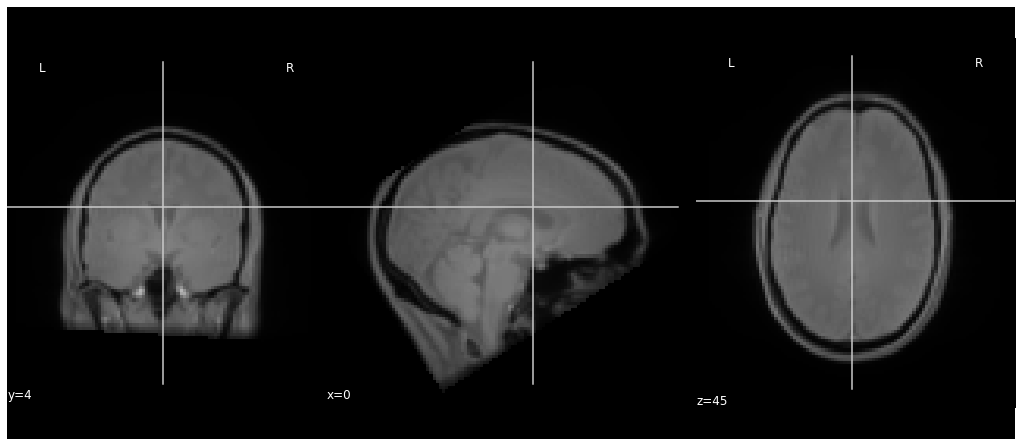

In [11]:
fig = plt.figure(figsize=(14,6))
plot_anat(meanimg_stage1.to_nibabel(), figure=fig, cut_coords=[0, 4, 45])

### Stage 2: register each session to mean from stage 1


In [12]:

meanmag1 = np.zeros(meanimg_stage1.shape)
meanphasediff = np.zeros(meanimg_stage1.shape)

for session in sessions:
    mag1 = ants.image_read(sessions[session]['magnitude1'])
    reg_result = ants.registration(fixed=meanimg_stage1, moving=mag1, type_of_transform = 'Rigid' )
    sessions[session]['magnitude1_reg2mean'] = reg_result['warpedmovout']

    sessions[session]['magnitude1_reg2mean'].to_filename(
        os.path.join(sessions[session]['derivdir'],
                     f"sub-{sessions[session]['metadata']['subject']}_ses-{session}_magnitude1reg2mean.nii.gz"))
    meanmag1 += sessions[session]['magnitude1_reg2mean'][...]

    sessions[session]['magnitude2_reg2mean'] = ants.apply_transforms(
        fixed=meanimg_stage1,
        moving=ants.image_read(sessions[session]['magnitude2']),
        transformlist=reg_result['fwdtransforms'])

    sessions[session]['phasediff_reg2mean'] = ants.apply_transforms(
        fixed=meanimg_stage1,
        moving=ants.image_read(sessions[session]['phasediff']),
        transformlist=reg_result['fwdtransforms'])
    
    sessions[session]['phasediff_reg2mean'].to_filename(
        os.path.join(sessions[session]['derivdir'],
                     f"sub-{sessions[session]['metadata']['subject']}_ses-{session}_phasediffreg2mean.nii.gz"))
    meanphasediff += sessions[session]['phasediff_reg2mean'][...]


In [13]:
meanmagimg = meanimg_stage1.new_image_like(meanmag1 / len(sessions)).to_nibabel()
meanphasediffimg = meanimg_stage1.new_image_like(meanphasediff / len(sessions)).to_nibabel()


### Show all mag and phase images for QC

/var/folders/c4/hpq2bp2913j7jb77b6v5b7qh0000gn/T/ipykernel_49639/1064334922.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



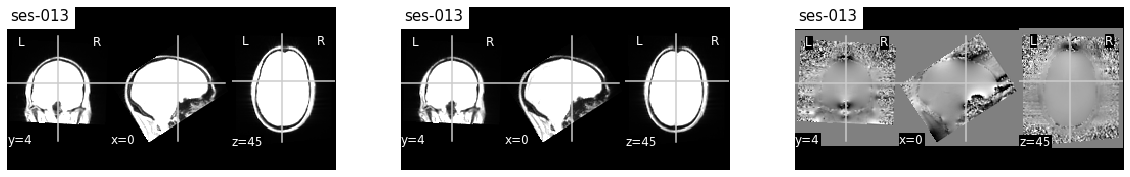

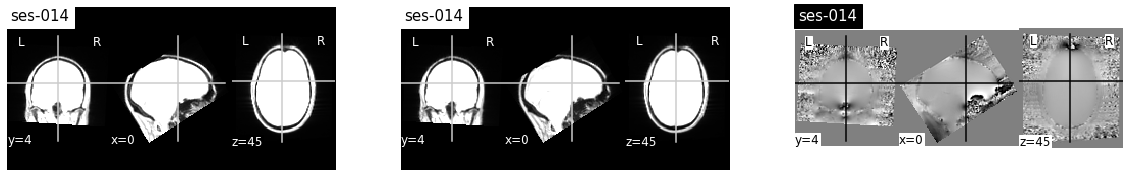

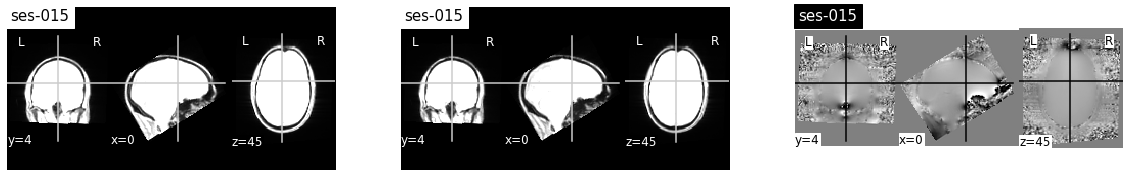

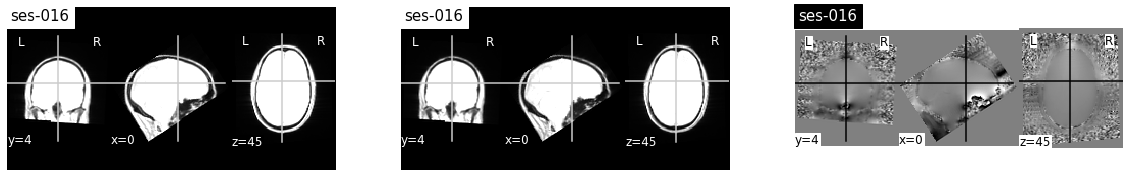

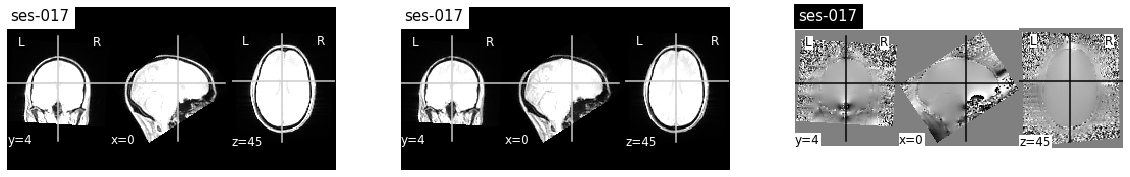

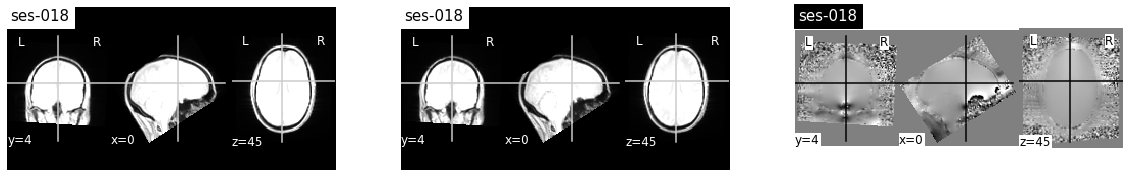

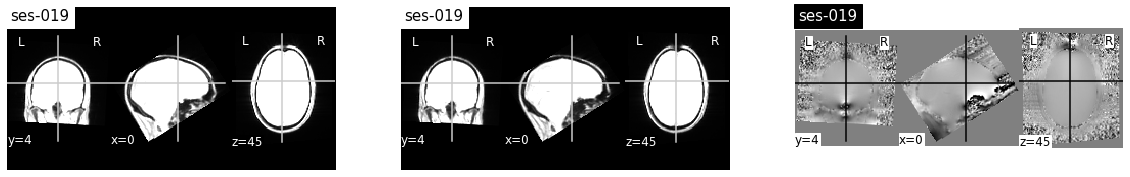

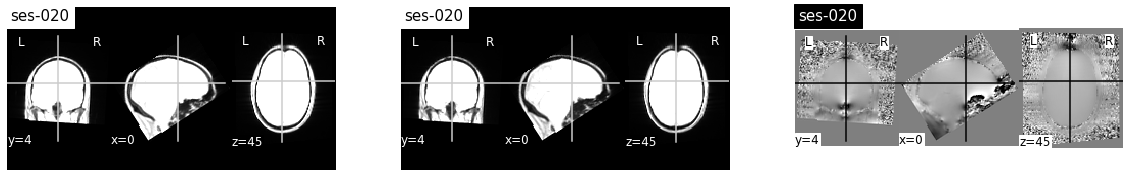

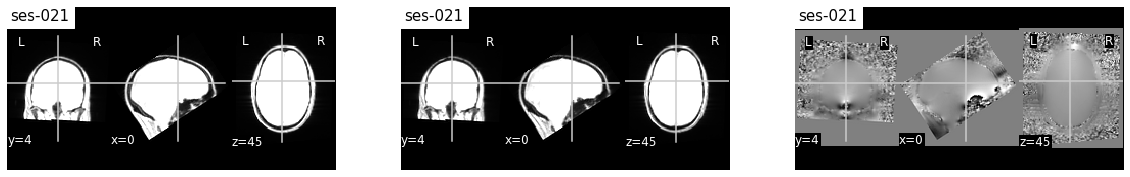

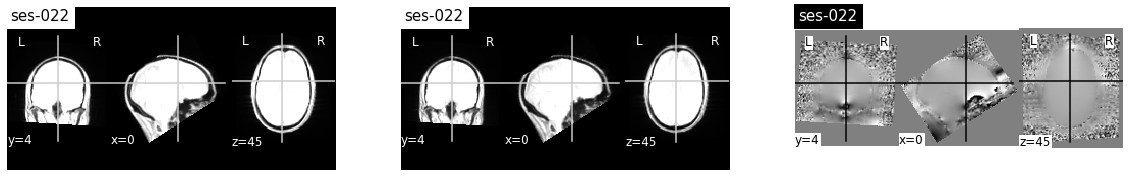

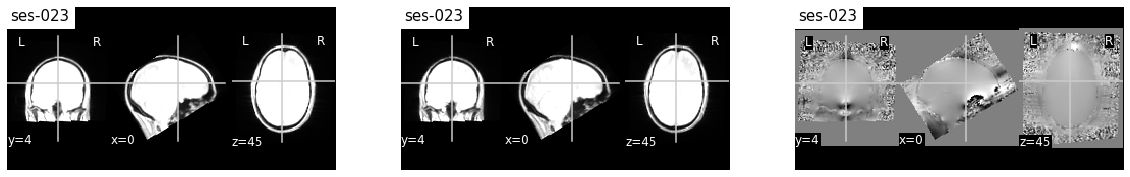

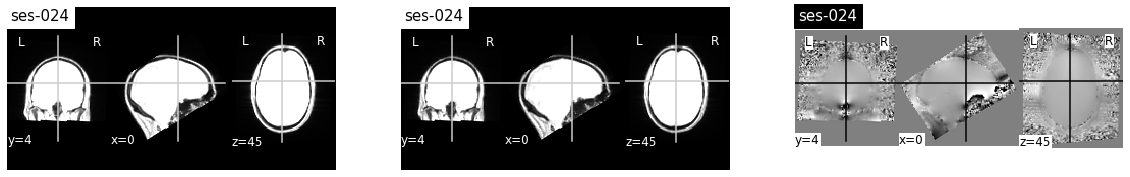

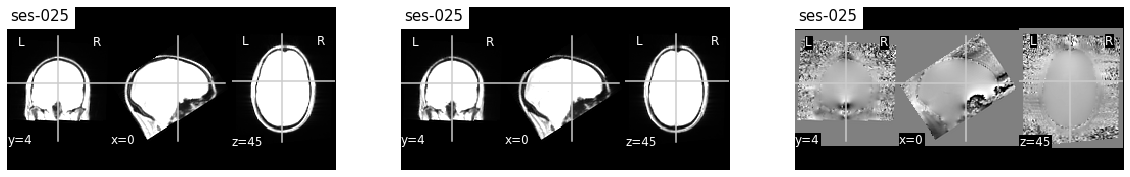

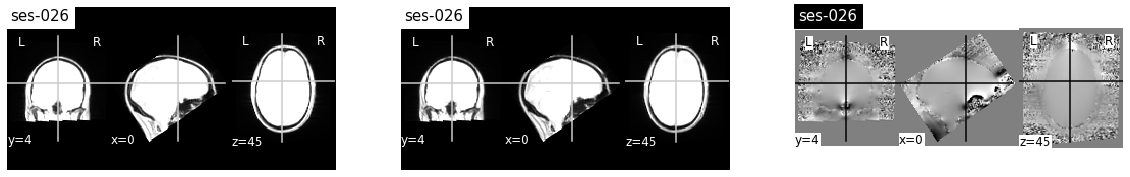

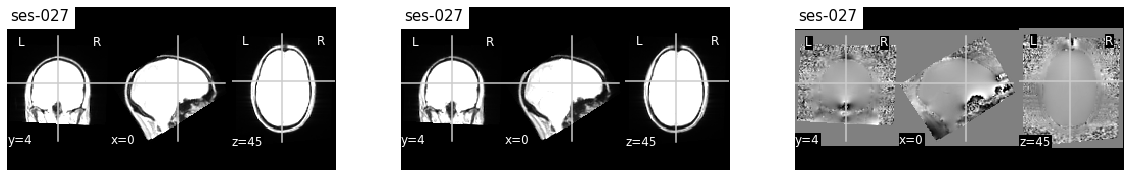

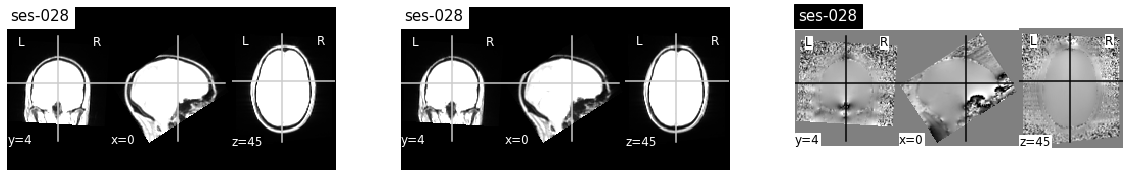

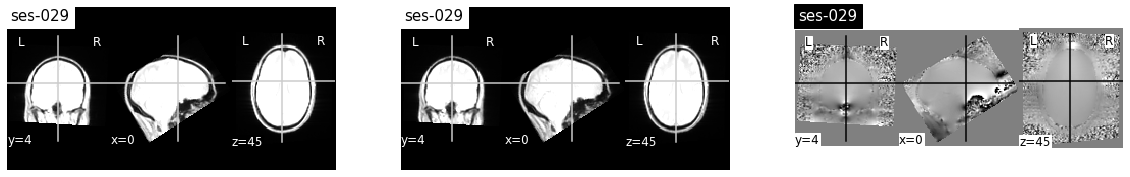

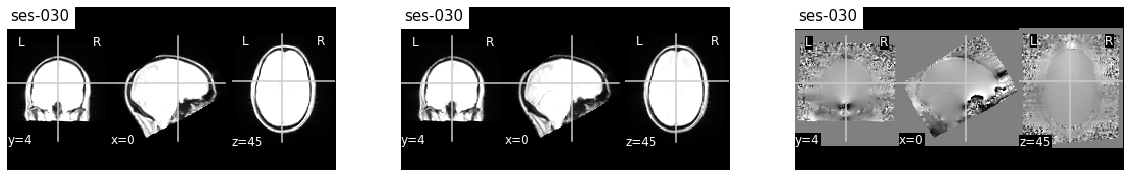

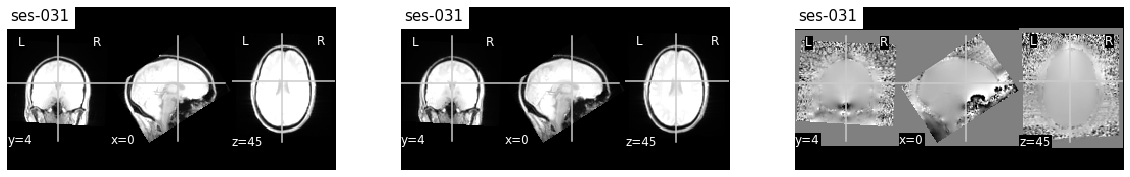

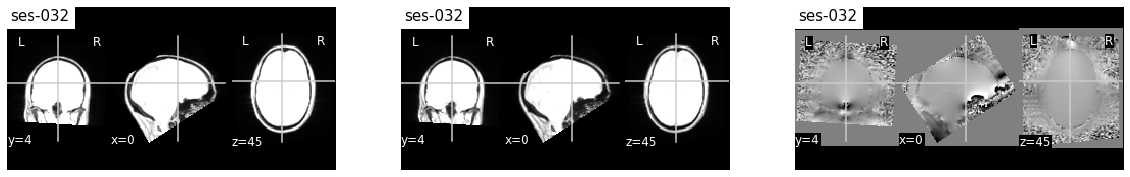

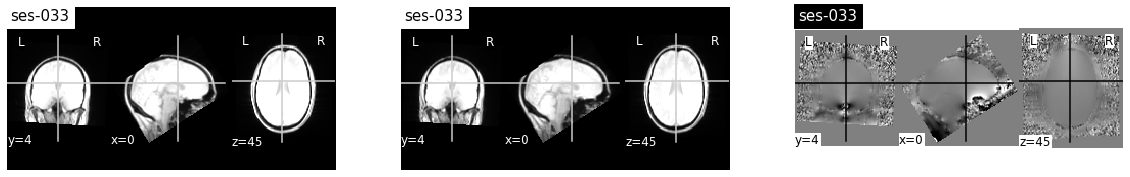

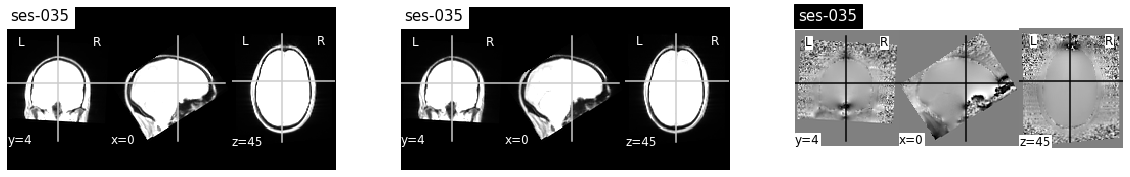

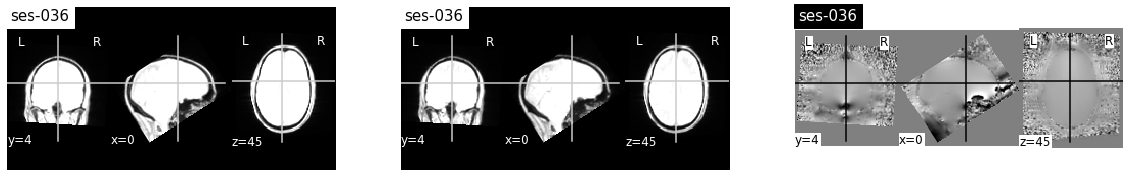

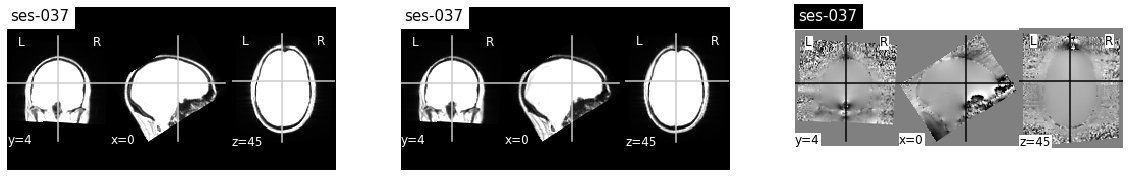

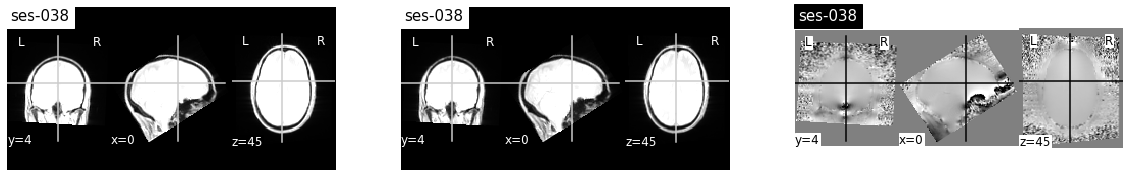

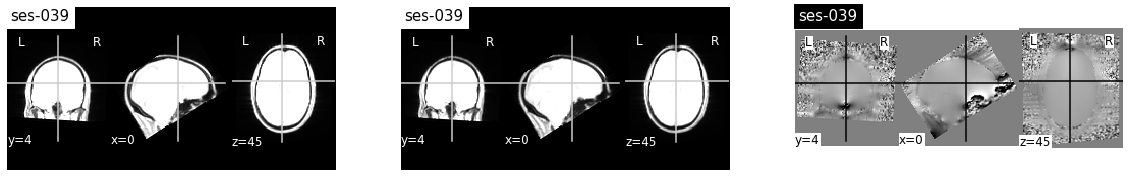

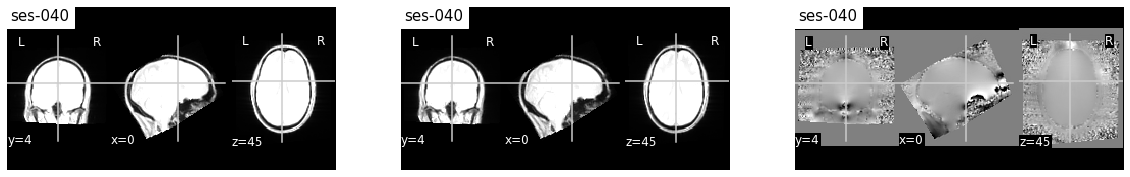

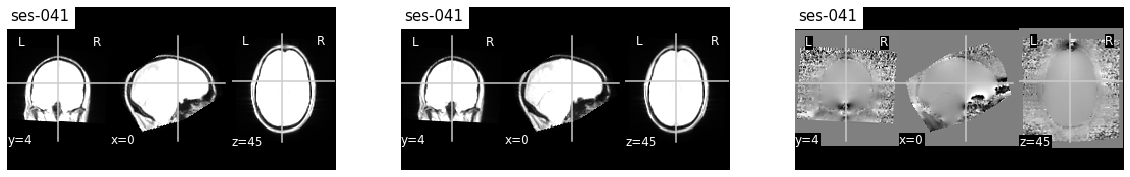

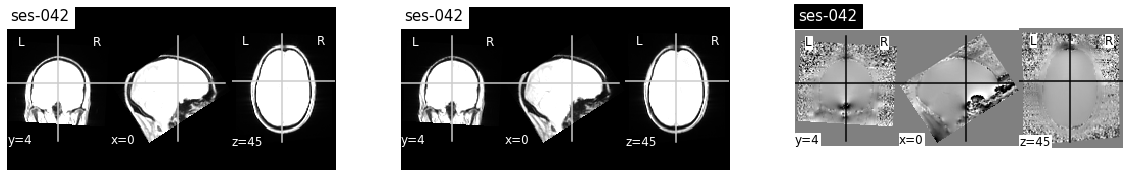

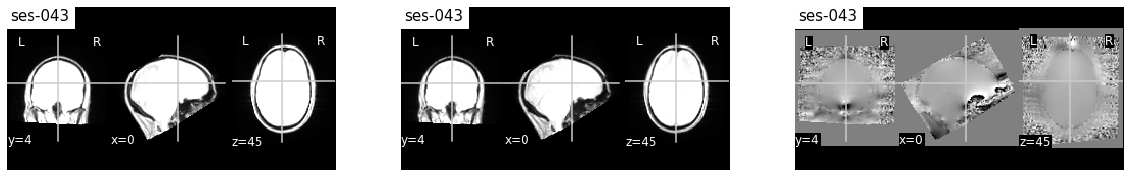

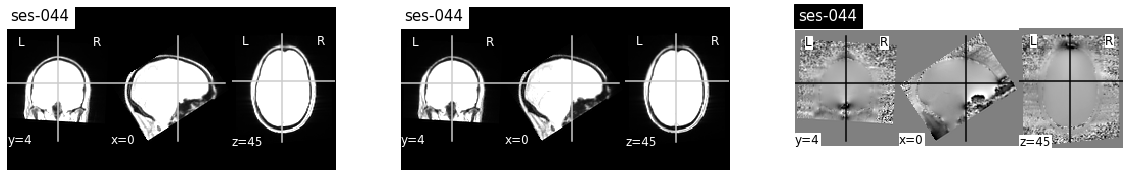

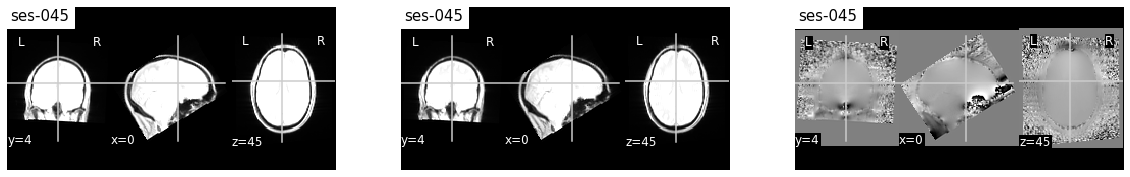

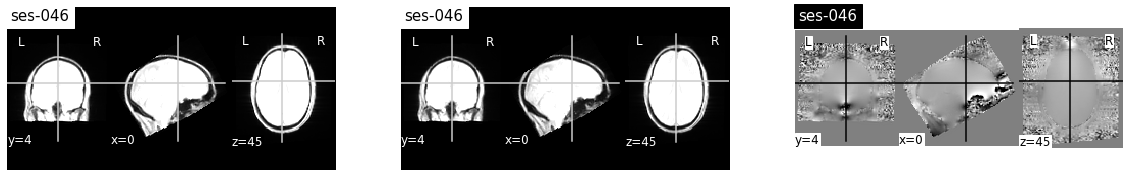

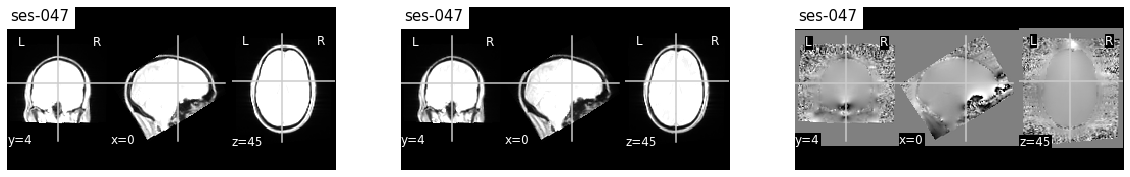

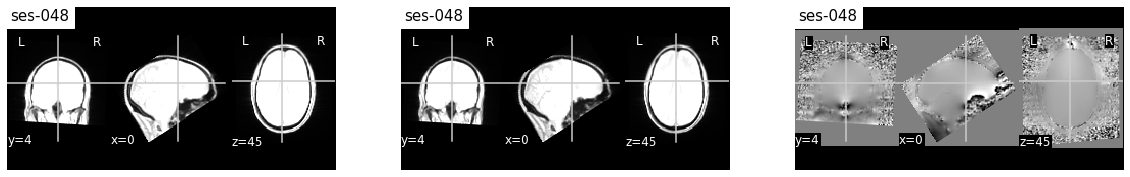

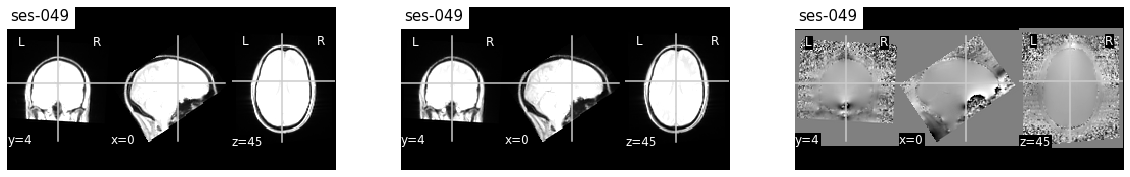

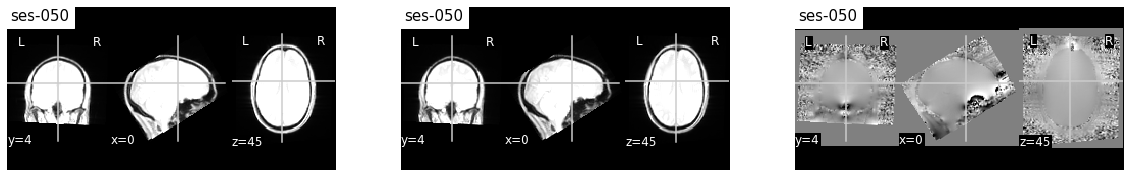

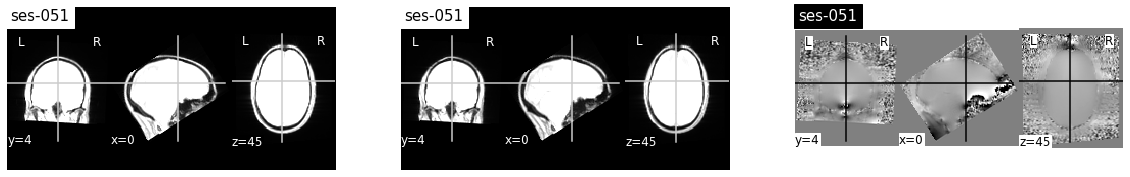

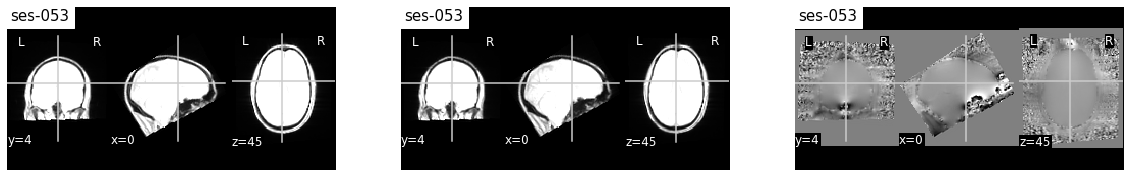

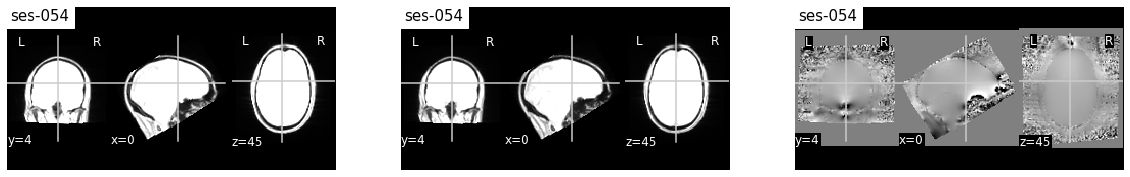

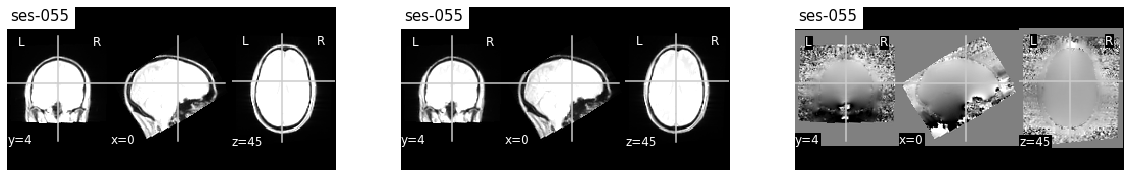

In [28]:
for session in sessions:
    fig, ax = plt.subplots(1, 3, figsize=(20,3))
    plot_anat(sessions[session]['magnitude1_reg2mean'].to_nibabel(), axes=ax[0], title=f'ses-{session}', vmax=500, cut_coords=[0, 4, 45])
    plot_anat(sessions[session]['magnitude2_reg2mean'].to_nibabel(), axes=ax[1], title=f'ses-{session}', vmax=500, cut_coords=[0, 4, 45])
    plot_anat(sessions[session]['phasediff_reg2mean'].to_nibabel(), axes=ax[2], title=f'ses-{session}', cut_coords=[0, 4, 45],
             vmin=-3000, vmax=3000)

(array([  6113.,  20904.,  36876.,  59682., 127187., 123115., 147038.,
         86226.,  15824.,   3723.]),
 array([-4055.5688  , -3242.6768  , -2429.785   , -1616.8928  ,
         -804.0008  ,     8.891235,   821.78326 ,  1634.6753  ,
         2447.5674  ,  3260.4592  ,  4073.3513  ], dtype=float32),
 <BarContainer object of 10 artists>)

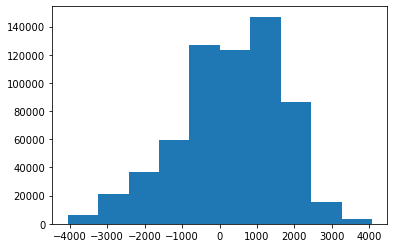

In [31]:
plt.hist(sessions[session]['phasediff_reg2mean'][...].flatten())